In [1]:
import numbers
import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
import docplex
import docplex.mp.model
import control
import control.matlab

import utility as util

In [32]:
def get_state_space_representation():
    """Get state-space representation of double integrator model."""
    # A, sys.A both have shape (4, 4)
    A = np.diag([1, 1], k=2)
    # B, sys.B both have shape (4, 2)
    B = np.concatenate((np.diag([0,0]), np.diag([1,1]),))
    # C has shape (2, 4)
    C = np.concatenate((np.diag([1,1]), np.diag([0,0]),), axis=1)
    # D has shape (2, 2)
    D = np.diag([0, 0])
    sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), 0.5)
    A = np.array(sys.A)
    B = np.array(sys.B)
    return (A, B)

def make_global_params():
    """Get Global LCSS parameters used across all loops"""
    params = util.AttrDict()
    params.M_big = 1000
    params.A, params.B = get_state_space_representation()
    # number of state variables x, number of input variables u
    # nx = 4, nu = 2
    params.nx, params.nu = params.B.shape
    bbox_lon, bbox_lat = 4.5, 2.5
    # params.diag = np.sqrt(bbox_lon**2 + bbox_lat**2) / 2.
    params.diag = 0.
    # Prediction parameters
    params.T = 5
    params.L = 4 # number of faces of obstacle sets

    # Closed for solution of control without obstacles
    A, B, T, nx, nu = params.A, params.B, params.T, params.nx, params.nu
    # C1 has shape (nx, T*nx)
    C1 = np.zeros((nx, T*nx,))
    # C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
    C2 = np.kron(np.eye(T - 1), A)
    # C3 has shape (nx*(T - 1), nx)
    C3 = np.zeros(((T - 1)*nx, nx,))
    # C, Abar have shape (nx*T, nx*T)
    C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
    Abar = np.eye(T * nx) - C
    # Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
    Bbar = np.kron(np.eye(T), B)
    # Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
    Gamma = np.concatenate((np.zeros((nx, T*nu,)),
            np.linalg.solve(Abar, Bbar),))
    params.Abar = Abar
    params.Bbar = Bbar
    params.Gamma = Gamma

    params.p_0_x = 3.
    params.p_0_y = 0.
    params.v_0_x = 0
    params.v_0_y = 0.3
    p_0_x, p_0_y, v_0_x, v_0_y = params.p_0_x, params.p_0_y, params.v_0_x, params.v_0_y
    
    # x0 : np.array
    #   Initial state
    x0 = np.array([p_0_x, p_0_y, v_0_x, v_0_y])
    A, T = params.A, params.T
    params.theta = np.angle(v_0_x + 1j*v_0_y)
    # params.v_lim = 8.33
    params.v_lim = 2.
    # States_free_init has shape (nx*(T+1))
    params.States_free_init = np.concatenate([
            np.linalg.matrix_power(A, t) @ x0 for t in range(T+1)])
    return params

def compute_velocity_constraints(param, v_x, v_y):
    """Velocity states have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Street speed limit is 30 km/h == 8.33.. m/s"""
    v_lim = param.v_lim # is m/s
    theta = param.theta
    r = v_lim / 2
    v_1 = r
    v_2 = 0.75 * v_lim
    c1 = v_2*((v_x - r*np.cos(theta))*np.cos(theta) \
            + (v_y - r*np.sin(theta))*np.sin(theta))
    c2 = v_1*((v_y - r*np.sin(theta))*np.cos(theta) \
            - (v_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(v_1 * v_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

def compute_acceleration_constraints(param, u_x, u_y):
    """Accelaration control inputs have coupled constraints.
    Generate docplex constraints for velocity for double integrators.

    Present performance cars are capable of going from 0 to 60 mph in under 5 seconds.
    Reference:
    https://en.wikipedia.org/wiki/0_to_60_mph"""
    theta = param.theta
    r = -2.5
    a_1 = 7.5
    a_2 = 5.0
    c1 = a_2*((u_x - r*np.cos(theta))*np.cos(theta) \
            + (u_y - r*np.sin(theta))*np.sin(theta))
    c2 = a_1*((u_y - r*np.sin(theta))*np.cos(theta) \
            - (u_x - r*np.cos(theta))*np.sin(theta))
    c3 = np.abs(a_1 * a_2)
    constraints = []
    constraints.extend([ z <= c3 for z in  c1 + c2 ])
    constraints.extend([ z <= c3 for z in -c1 + c2 ])
    constraints.extend([ z <= c3 for z in  c1 - c2 ])
    constraints.extend([ z <= c3 for z in -c1 - c2 ])
    return constraints

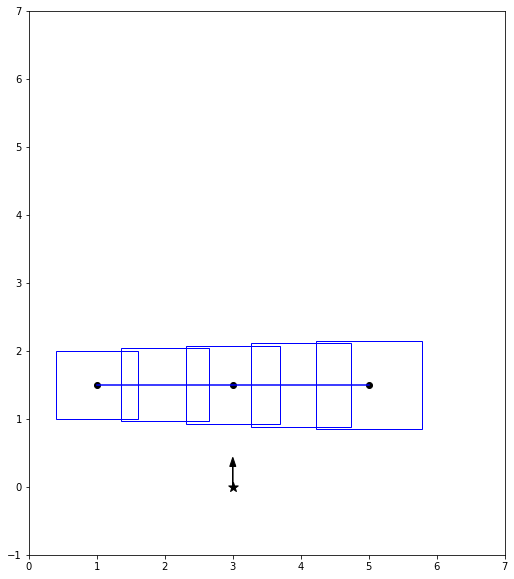

In [33]:
params = make_global_params()
T = params.T
p_0_x, p_0_y, v_0_x, v_0_y = params.p_0_x, params.p_0_y, params.v_0_x, params.v_0_y
fig, ax = plt.subplots(figsize=(10, 10))

dist = 1.5
points = np.array([
        [1, dist],
        [3, dist],
        [5, dist]])
ax.plot(*points.T, 'ok');
interp_points = util.interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-b');
lw = util.kronecker_mul_vectors(np.array([1.2, 1.]), np.linspace(1,1.3, T))
vertex_set_1 = util.place_rectangles_on_intep_curve(points, T, lw)

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='blue', fc='none')
    ax.add_patch(patch)

ax.scatter(p_0_x, p_0_y, marker='*', c='k', s=100)
ax.arrow(p_0_x, p_0_y, v_0_x, v_0_y, color='k', head_width=0.09)

ax.set_aspect('equal')
ax.set_xlim([0, 7])
ax.set_ylim([-1, 7])

A_union = [None]*T
b_union = [None]*T
# vertex_set_x has shape (8, 4, 2)
for t, vertices in enumerate(vertex_set_1):
    A, b = util.vertices_to_halfspace_representation(vertices)
    A_union[t] = A
    b_union[t] = b

In [34]:
"""Apply motion planning problem"""
model = docplex.mp.model.Model(name="proposed_problem")
L, T, Gamma, nu, nx = params.L, params.T, \
        params.Gamma, params.nu, params.nx
u = np.array(model.continuous_var_list(nu*T, lb=-np.inf, ub=np.inf, name='u'), dtype=object)
Delta = np.array(model.binary_var_list(L*T, name='delta'), dtype=object).reshape(T,L)

X = (params.States_free_init + util.obj_matmul(Gamma, u)).reshape(T+1,nx)
_X = X[1:]
U = u.reshape(T,nu)

model.add_constraints(compute_velocity_constraints(params, _X[:,2], _X[:,3]))
model.add_constraints(compute_acceleration_constraints(params, U[:,0], U[:,1]))

_X = X[1:,:2]
T, diag, M_big = params.T, params.diag, params.M_big
for t in range(T):
    A = A_union[t]
    b = b_union[t]
    lhs = util.obj_matmul(A, _X[t]) + M_big*(1 - Delta[t])
    rhs = b + diag
    model.add_constraints([l >= r for (l,r) in zip(lhs, rhs)])
    model.add_constraint(np.sum(Delta[t]) >= 1)

# start from current vehicle position and minimize the objective
p_0_x, p_0_y = params.p_0_x, params.p_0_y
goal_x, goal_y = p_0_x + 0, p_0_y + 7
start = np.array([p_0_x, p_0_y])
goal = np.array([goal_x, goal_y])
_X = X[1:]
cost = 0.
for t in range(T):
    cost += (_X[t,0] - goal_x)**2 + (_X[t,1] - goal_y)**2
    cost += 0.2*t*(_X[t,2]**2 + _X[t,3]**2)

model.minimize(cost)
# model.print_information()
# model.parameters.read.datacheck = 1
should_log_cplex = True
if should_log_cplex:
    model.parameters.mip.display = 2
    s = model.solve(log_output=True)
else:
    model.solve()
# model.print_solution()

f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
U_star = util.obj_vectorize(f, U)
cost = cost.solution_value
X_star = util.obj_vectorize(f, X)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 5 rows and 4 columns.
MIQP Presolve modified 86 coefficients.
Reduced MIQP has 60 rows, 26 columns, and 248 nonzeros.
Reduced MIQP has 16 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 50 nonzeros.
Presolve time = 0.00 sec. (0.28 ticks)
Probing fixed 2 vars, tightened 0 bounds.
Probing time = 0.00 sec. (0.15 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 2 rows and 2 columns.
MIQP Presolve modified 28 coefficients.
Aggregator did 1 substitutions.
Reduced MIQP has 57 rows, 23 columns, and 238 nonzeros.
Reduced MIQP has 13 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 50 nonzeros.
Presolve time = 0.00 sec. (0.14 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
MIQP Presolve modified 27 coefficients.
Reduced MIQP has 57 rows, 23 col

(-1.0, 8.0)

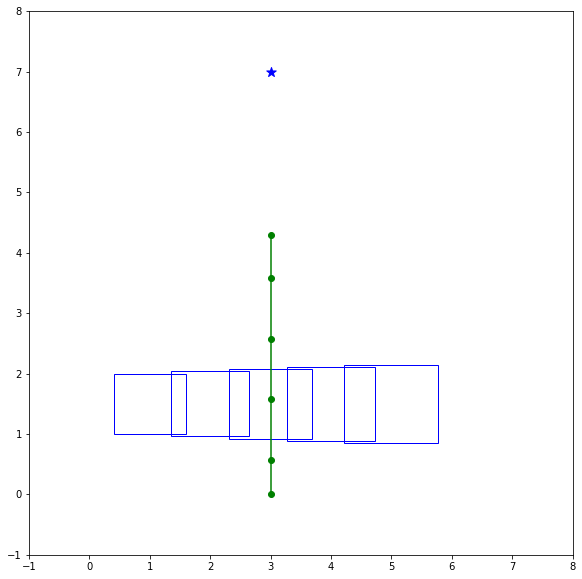

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

for vertices in vertex_set_1:
    patch = patches.Polygon(vertices, closed=True, color='blue', fc='none')
    ax.add_patch(patch)

X = X_star[:,:2]
ax.plot(*X.T, '-go')
ax.scatter(*goal, marker='*', s=100, c='b')

ax.set_aspect('equal')
ax.set_xlim([-1, 8])
ax.set_ylim([-1, 8])